# SVM demo using scikit-learn

In this module, you will:
* Try different SVMs (linear, non-linear) on synthetic data and the iris data
* Create contour plots over 2-dimensional features
* Run SVM on MNIST (multiple-class classification over images)

MNIST image is 28*28 pixels, or 784 dimensions. File location: https://www.openml.org/d/554

You can upload MNIST data into Colab. Click the folder icon on the left, and click the upload button on the left pannel.

# Synthetic data (2-class)

In [1]:
import matplotlib.pyplot as plt
import sklearn 
import numpy as np

# This function is the only styling that we're going to do

# Given an 2D range, it will evaluate the SVM on the whole
# range to produce a colored plot which shows you the 
# scoring/probabilities.
def plot_colors(ax, predict_fun, xrange=(-3,3.5), yrange=(-3,3)):
    # store current ax limits so we can reset them later
    xl,yl = ax.get_xlim(),ax.get_ylim()
    
    # generate a grid to plot on
    # prepare the xs and ys
    x0x0, x1x1 = np.meshgrid(np.arange(min(xrange), max(xrange), .01), np.arange(min(yrange), max(yrange), .01))

    # flatten xs and ys, forming [x,y] pairs to feed to the predict_function, returning their distances of each point on the grid from the decision boundary
    Z          = predict_fun(np.c_[x0x0.ravel(), x1x1.ravel()]) 

    # reshape the distances back to 2-D as in the meshgrid. Now each point on the mesh has a distance value wrt to the decision boundary
    Z          = Z.reshape(x0x0.shape)

    # plot the contour. Points that have the distances from the decision boundary form a contour.
    cf         = ax.contourf(x0x0, x1x1, Z, cmap=plt.cm.Blues_r, alpha=0.5);
    
    ax.set(xlim = xl, ylim=yl)
    return ax

In [2]:
# demonstrate how the meshgrid works
xs, ys = np.meshgrid(np.arange(0, 5), np.arange(0, 3))
print(xs)
# flatten into 1-D
print(xs.ravel())
print(ys)
# flatten into 1-D
print(ys.ravel())
# create the x-y coordinate pairs
print(np.c_[xs.ravel(), ys.ravel()])

[[0 1 2 3 4]
 [0 1 2 3 4]
 [0 1 2 3 4]]
[0 1 2 3 4 0 1 2 3 4 0 1 2 3 4]
[[0 0 0 0 0]
 [1 1 1 1 1]
 [2 2 2 2 2]]
[0 0 0 0 0 1 1 1 1 1 2 2 2 2 2]
[[0 0]
 [1 0]
 [2 0]
 [3 0]
 [4 0]
 [0 1]
 [1 1]
 [2 1]
 [3 1]
 [4 1]
 [0 2]
 [1 2]
 [2 2]
 [3 2]
 [4 2]]


## Use LinearSVC, dual=False
* When number of data points >> number of features, recommend solving the primal. 

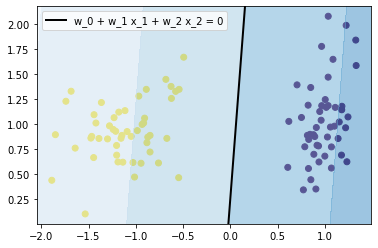

In [3]:
from sklearn.datasets import make_classification
from sklearn.svm import LinearSVC

fig,ax = plt.subplots(1,1)

# create and plot the data (2-class)
# flip_y controls the amount of noise by flipping the sign of the labels
X, y = make_classification(n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1, flip_y=0.01)

# 2-dimension scatter plot with label
ax.scatter(X[:,0],X[:,1],c=y);

# run the SVM
#  - C  is a parameter used to trade-off complexity (1/lambda regularization parameter),
#       you will want to tune it using GridSearch or similar
#  - dual is needed to tell sklearn that we want to operate in the primal space
clf = LinearSVC(dual=False, C=1)
clf.fit(X, y)

# plot the distances to the plane
plot_colors(ax, clf.decision_function)

# plot the actual SVM decision line
x2 = np.arange(-0.2,2.2,.1)
x1 = (- clf.intercept_ - clf.coef_[0,1]*x2)/clf.coef_[0,0]
ax.plot(x1, x2, color="black", linewidth=2, label="w_0 + w_1 x_1 + w_2 x_2 = 0")
ax.legend()


In [4]:
clf.decision_function # This is the underlying function to evaluate the decision function, i.e. the distances of each data point from the decision boundary.

<bound method LinearClassifierMixin.decision_function of LinearSVC(C=1, dual=False)>

In [5]:
print(clf.coef_)
print(clf.intercept_)

# the purple point (1,0) is on the right side of the decision boundary
print("(1,0), distance = {}".format(clf.decision_function([[1, 0]])))

# the yellow point (-1,0) is on the left side of the decision boundary
print("(0,1), distance = {}".format(clf.decision_function([[-1, 0]])))

[[-1.39498824  0.11311434]]
[-0.03073823]
(1,0), distance = [-1.42572646]
(0,1), distance = [1.36425001]


## Dual, Non-linear
* Penalty $C$ to control the influence of slack variables. In other words, it controls if misclassifying a training sample is a big deal.
* For large $C$, it means that misclassifying a training sample will incur a large penalty. Therefore, SVM will try to look for a decision boundary that fits the training data well, which may sacrifice with a hyperplane with a small margin.
* For small $C$, it is the opposite. Misclassifying a training sample is not a big deal. What we want is to achieve a bigger margin and can tolerate some training points that lie on the 'wrong' side of the decision boundary. These points may be outliers (i.e. noisy labeled samples) and that we should ignore them.
* Kernel parameter $\gamma = \frac{1}{2\sigma^2}$


<AxesSubplot:>

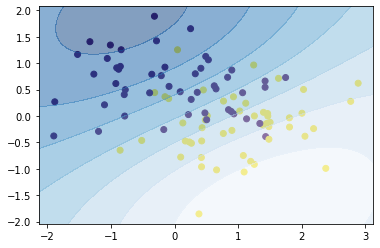

In [6]:
from sklearn.datasets import make_moons
from sklearn.svm import SVC

fig,ax = plt.subplots(1,1)

# create some data that cannot be separated linearly and plot the data
X, y = make_moons(random_state=1, noise=0.5)
ax.scatter(X[:,0],X[:,1],c=y)

# run the SVM
#  - dual=False is needed to tell sklearn that we want to operate in the primal space?
clf = SVC(kernel="rbf", C=1, gamma = 0.1)

# Convince yourself that small gamma => large variance in Gaussian kernel => bigger data window to consider => contour more smooth
# Conversely, large gamma => small variance => less data to consider in kernel => contour very non-linear
# So, play in the middle range, and tune the best gamma

# very small gamma, decision boundary too smooth
# clf = SVC(kernel="rbf", C=1.0 , gamma = 0.00001)

# very large gamma: heavily overfitted
# clf = SVC(kernel="rbf", C=1.0 , gamma = 1000.0)

clf.fit(X, y)

# plot the distances to the plane
plot_colors(ax, clf.decision_function)

# IRIS data (3-class)

/Users/yunjiesong/opt/anaconda3/envs/machinelearning/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


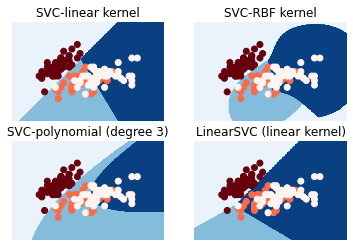

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets

# import some data to play with
iris = datasets.load_iris()
X = iris.data[:, :2]  # we only take the first two features. We could
                      # avoid this ugly slicing by using a two-dim dataset
Y = iris.target # 3-class problem

# we create an instance of SVM and fit our data. We do not scale our
# data since we want to plot the support vectors
C = 100.0  # SVM regularization parameter
svc = svm.SVC(kernel='linear', C=C).fit(X, Y)

# check it to learn more about the gamma parameter in rbf
# https://towardsdatascience.com/radial-basis-function-rbf-kernel-the-go-to-kernel-acf0d22c798a
# https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html
rbf_svc = svm.SVC(kernel='rbf', gamma=0.7, C=C).fit(X, Y)
poly_svc = svm.SVC(kernel='poly', degree=3, C=C).fit(X, Y)
lin_svc = svm.LinearSVC(C=C).fit(X, Y)

# create a mesh to plot
h = .02  # step size in the mesh
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# print (xx)
# print (yy)
# print (np.c_[xx.ravel(), yy.ravel()])

# title for the plots
titles = ['SVC-linear kernel',
          'SVC-RBF kernel',
          'SVC-polynomial (degree 3)',
          'LinearSVC (linear kernel)']
          
for i, model in enumerate((svc, rbf_svc, poly_svc, lin_svc)):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].
    plt.subplot(2, 2, i + 1)
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, cmap=plt.cm.Blues)
    plt.axis('off')

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Reds_r)

    plt.title(titles[i])

plt.show()

### LinearSVC vs. SVM
The SVM module (SVC, NuSVC, etc) is a wrapper around the libsvm library and supports different kernels while LinearSVC is based on liblinear and only supports a linear kernel.
Theoretically, SVC(kernel = 'linear') is equivalent to LinearSVC().
Because the implementations are different in practice you will get different results, the most important ones being that LinearSVC only supports a linear kernel, is faster and can scale a lot better.

# MNIST data (10-class)

We will be using the MNIST dataset, which is a set of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau. Each image is labeled with the digit it represents. This set has been studied so much that it is often called the “hello world” of Machine Learning: whenever people come up with a new classification algorithm they are curious to see how it will perform on MNIST, and anyone who learns Machine Learning tackles this dataset sooner or later.

In [8]:
# Let's setup the experiment
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.datasets import fetch_openml
import numpy as np
import pandas as pd

try:
    # mount the google drive
    from google.colab import drive
    drive.mount('/content/drive')
except:
    print("No Google drive can be mounted. Access file locally")
    pass

# fetch the mnist data
mnist = fetch_openml('mnist_784')
X, y = mnist.data, mnist.target

# Alternatively, read the local data
# mnist_csv = pd.read_csv('mnist_784.zip', sep=',')

# # take all feature columns
# X = mnist_csv.iloc[:, :-1].values

# # last column is target label. Cast them into integers
# y = mnist_csv.iloc[:, -1].values.astype(np.int32)
# mnist_csv.describe()

No Google drive can be mounted. Access file locally


In [9]:
pd.DataFrame(X, columns = mnist.feature_names)

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


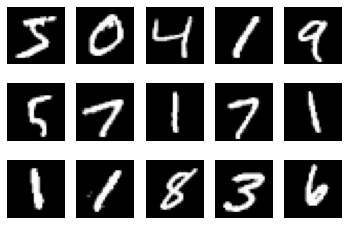

In [10]:
# See some data images
counter = 1
for i in range(3):
    for j in range(5):
        # create 3 x 5 subplots to check the data
        plt.subplot(3, 5, counter)
        plt.imshow(X[i * 100 + j].reshape((28,28)), cmap=cm.Greys_r)
        plt.axis('off')
        counter += 1
plt.show()

In [11]:
from sklearn.model_selection import train_test_split

# normalize the data somehow
# after the transformation, all values are between -1 and 1
X = X / 255.0 * 2 - 1

# split the dataset into train and test 
#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=11)

# first 60k as train, last 10k as test, as indicated in openml.org)
num_train = 60000
num_test = 10000
X_train = X[:num_train]
X_test = X[-num_test:]
y_train = y[:num_train]
y_test = y[-num_test:]

#np.bincount(y_train)
print(y_train.shape)

(60000,)


In [13]:
import time
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# build the ML pipeline
pipeline = Pipeline([
    ('clf', SVC(kernel='rbf', gamma=0.01, C=1, random_state=1))
#    ('clf', LinearSVC(dual=False))
])

time1 = time.time()

pipeline.fit(X_train[:10000], y_train[:10000])

time2 = time.time()
print('Time: {}'.format(time2 - time1))

Time: 43.4641489982605


In [14]:
# report Accuracy based on the tuned result
from sklearn.metrics import accuracy_score

y_pred = pipeline.predict(X_test)

accuracy_score(y_test, y_pred)

0.9679

## Exercise 1: Use MNIST dataset and tune your SVM classifiers

## Exercise 2: Use MNIST dataset and use stochastic gradient descent to train SVM classifiers

Use sklearn.linear_model.SGDClassifier to build your model. Compare classification performance on a test set.

Check documentation: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier

* Check out n_jobs to use more cpus to run